In [8]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

In [9]:
DATA_DIR = '/home/tatiana/MADE_Ubuntu/MADE_2/RecSys/data/'# "/Users/n.anokhin/Desktop/"
# data = pd.read_json("/home/tatiana/MADE_Ubuntu/MADE_2/RecSys/data/data.json", lines=True)

In [13]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

In [14]:
positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) >= 0.7

In [15]:
user_counts = positives[~positives["test"]].groupby("user").size()
users = set(user_counts[user_counts >= 5].index.values)

In [16]:
track_counts = positives[~positives["test"]].groupby("track").size()
tracks = set(track_counts[track_counts >= 5].index.values)

In [17]:
len(users)

117

In [18]:
len(tracks)

62

## Train LightFM

In [19]:
train_data = positives[~positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]
test_data = positives[positives["test"] & positives["user"].isin(users) & positives["track"].isin(tracks)]

len(train_data), len(test_data)

(275, 90)

In [20]:
dataset = ld.Dataset()
dataset.fit(users, tracks)

In [21]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [26]:
train_interactions.shape, test_interactions.shape

((117, 62), (117, 62))

In [27]:
def fit_model(
    epochs=1, 
    at=10,
    loss="warp",
    no_components=30,
    learning_rate=0.01, 
    max_sampled=10,
    user_alpha=0.0, 
    item_alpha=0.0, 
    threads=30, 
    verbose=False,
    patience=3,
    epsilon=1e-6,
):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
            
        precisions_at.append(np.mean(precision_at))
            
        if epoch > patience and all([precisions_at[-j] - precisions_at[-patience-1] < epsilon for j in range(1, patience + 1)]):
            if verbose:
                print("Early stopiing!")
            break
        
    else:
        if verbose:
            print("No early stopiing happened: increase epochs maybe?")
        
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["warp", "bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.0001, 0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.0001])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.0001])
    
    model, precisions_at = fit_model(
        epochs=5, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [39]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)
best_params = study.best_params

[I 2023-04-07 22:32:12,460] A new study created in memory with name: no-name-ccb3e023-b15d-424a-be3a-a76728db774f
[I 2023-04-07 22:32:12,535] Trial 0 finished with value: 0.03478261083364487 and parameters: {'loss': 'warp', 'no_components': 30, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0001, 'item_alpha': 0.0001}. Best is trial 0 with value: 0.03478261083364487.
[I 2023-04-07 22:32:12,614] Trial 1 finished with value: 0.05000000074505806 and parameters: {'loss': 'warp', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 20, 'user_alpha': 0.0, 'item_alpha': 0.0}. Best is trial 1 with value: 0.05000000074505806.
[I 2023-04-07 22:32:12,700] Trial 2 finished with value: 0.032608699053525925 and parameters: {'loss': 'bpr', 'no_components': 50, 'learning_rate': 0.01, 'max_sampled': 50, 'user_alpha': 0.0001, 'item_alpha': 0.0}. Best is trial 1 with value: 0.05000000074505806.
[I 2023-04-07 22:32:12,772] Trial 3 finished with value: 0.030434781685471535 and parameters: 

In [40]:
best_params

{'loss': 'warp',
 'no_components': 30,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.0,
 'item_alpha': 0.0001}

In [41]:
model, precisions_at = fit_model(
    epochs=200,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.02826087176799774 +/- 0.014498092897103633
1:	0.03478261083364487 +/- 0.016367260671876844
2:	0.03695652633905411 +/- 0.018637755129954765
3:	0.03695652633905411 +/- 0.018637755129954765
4:	0.03695652633905411 +/- 0.018637755129954765
5:	0.03478261083364487 +/- 0.01849651507720924
Early stopiing!


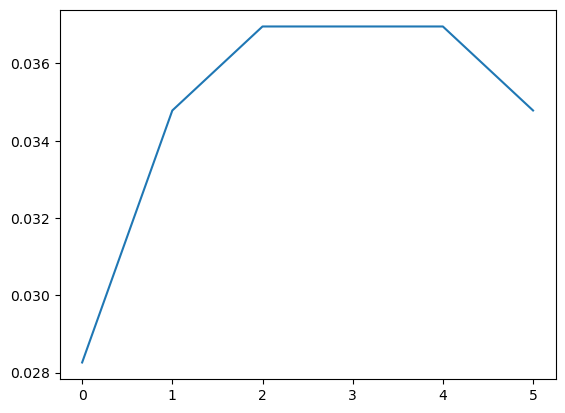

In [42]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [43]:
biases, embeddings = model.get_item_representations()

In [44]:
model.item_biases *= 0.0

In [48]:
track_meta = pd.read_json(DATA_DIR + "/tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

ValueError: Expected object or value

In [46]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

NameError: name 'track_meta' is not defined

In [43]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [44]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [45]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": int(users[user_index]),
            "tracks": [int(x) for x in top]
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7890/7890 [00:05<00:00, 1438.82it/s]
